    ==============================================================================================

## Importing the DataFrames
- ``` df = pd.read_pickle("file_name.pkl")```  --> create 1 df from a pkl file

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option("display.min_rows", 0) 
pd.set_option("display.max_rows", 30) 
pd.__version__

'1.4.4'

In [2]:
db_qu = pd.read_pickle("clean_Tables\Merged_c.pkl")

In [3]:

db_qu_rows = db_qu.shape[0]
db_qu_rows

60943

In [4]:
db_qu.columns

Index(['ORD_ID', 'ord_CreatDate', 'ord_TotlPaid', 'OL_ID', 'ol_ProdQnty',
       'ol_ProdUntPr', 'ol_ProcessDate', 'PRO_SKU', 'pro_Name', 'pro_Desc',
       'pro_Pr', 'pro_InStock', 'pro_Type'],
      dtype='object')

In [5]:
#ord_qu = db_qu[['ORD_ID', 'ord_CreatDate', 'ord_TotlPaid']].copy()

In [6]:
#ol_qu = db_qu[['OL_ID', 'ol_ProdQnty', 'ol_ProdUntPr', 'ol_ProcessDate']].copy()

In [7]:
#pro_qu = db_qu[['PRO_SKU', 'pro_Name', 'pro_Desc', 'pro_Pr', 'pro_InStock', 'pro_Type']].copy()

    ==============================================================================================

## Answer Bussines questions


- Concerns
    A. The main investors pointed out the company’s recent quarterly results showed
        1.  increase in orders placed but a decrease in the total revenue. They prefer that the company positions itself in the quality segment, rather than competing to offer the lowest prices in the market.
    B. Questions
        1. How products should be classified into different categories to simplify reports and analysis.
        2. What is the distribution of product prices across different categories.
        3. How many products are being discounted.
        4. How big are the offered discounts as a percentage of the product prices. --> tmp_dis_per

### A.1. Revenue per Order
- Recap:
    - ord_TotlPaid : total amount paid by the customer for this order (euros)
    - ol_ProdUntPr : the unitary price (euros) of each product at the moment of placing that order
    - ol_ProdQnty  : how many units of that product were purchased on that order
- per row(OL) : ol_ProdUntPr * ol_ProdQnty = tmp_ol_price
- group by ORD_ID .sum of the tmp_ol_price = tmp_ord_price
- compare the tmp_ord_price with ord_TotlPaid

In [8]:
drop_lst = ["ol_ProcessDate","PRO_SKU","pro_Name","pro_Desc","pro_InStock","pro_Type"]

In [9]:
db_qu["tmp_ol_price"] = db_qu.ol_ProdUntPr * db_qu.ol_ProdQnty

In [10]:
db_qu.tmp_ol_price.means="db_qu.ol_ProdUntPr * db_qu.ol_ProdQnty"

In [11]:

db_ordRev=(
    db_qu
    .groupby("ORD_ID")
    .agg(tmp_ord_Rev=('tmp_ol_price', 'sum'))
    .merge(db_qu,on="ORD_ID")
).drop_duplicates(subset="ORD_ID")

In [12]:
#db_ordRev.tmp_ord_Rev.means="groupby ORD_ID, agg tmp_ol_price --> sum"

In [13]:
#db_ordRev.tmp_ord_Rev.means

In [14]:

db_ordRev=(
    db_ordRev
    .assign(tmp_ord_Pr_diff = db_ordRev.ord_TotlPaid-db_ordRev.tmp_ord_Rev)
    .drop(columns=drop_lst)
    .drop(columns = ["tmp_ol_price","OL_ID","ol_ProdQnty",	"ol_ProdUntPr",	"pro_Pr"])
    .reindex(columns=['ORD_ID', 'ord_CreatDate', 'ord_TotlPaid', 'tmp_ord_Rev', 'tmp_ord_Pr_diff'])
)

In [15]:
# db_ordRev.tmp_ord_Pr_diff.means='''db_ordRev.ord_TotlPaid - db_ordRev.tmp_ord_Rev 
# In ideal cases, this value should 0
# +ve means customer paid extra costs (ie delivery)
# -ve means customer paid less than he should!! '''

In [16]:
db_ordRev.sample(5)

,ORD_ID,ord_CreatDate,ord_TotlPaid,tmp_ord_Rev,tmp_ord_Pr_diff
30575,417820,2017-10-25 22:35:09,321.99,318.00,3.99
56869,511257,2018-02-14 09:42:37,29.99,29.99,0.00
32358,423365,2017-11-08 13:26:09,1774.99,1774.99,0.00
56234,508804,2018-02-09 13:11:51,83.98,78.99,4.99
18657,376184,2017-07-12 17:43:37,2169.00,2169.00,0.00


In [17]:
db_ordRev.tmp_ord_Pr_diff.describe()

count    45905.000000
mean         7.351494
std         62.456507
min       -165.000000
25%          0.000000
50%          4.990000
75%          6.990000
max       3984.990000
Name: tmp_ord_Pr_diff, dtype: float64

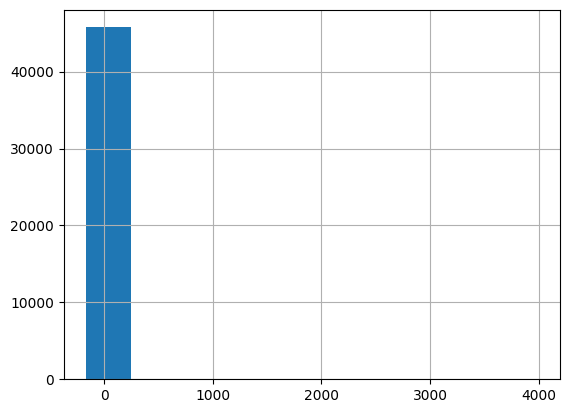

In [18]:
db_ordRev.tmp_ord_Pr_diff.hist();

Calculate Outlier

In [19]:
Q1 = db_ordRev.tmp_ord_Pr_diff.quantile(0.25)
Q3 = db_ordRev.tmp_ord_Pr_diff.quantile(0.75)
IQR=Q3-Q1

In [20]:
num_inliers =((db_ordRev.tmp_ord_Pr_diff >= (Q1 - 1.5*IQR)) & (db_ordRev.tmp_ord_Pr_diff <= (Q3 + 1.5*IQR))).sum()
num_outliers = db_ordRev.shape[0]-num_inliers 
per_outliers = round((num_outliers/db_ordRev.shape[0])*100,2)
print(f'''{num_outliers} out of {db_ordRev.shape[0]} are outliers from tmp_ord_Pr_diff ,ie {per_outliers}%''') 

1105 out of 45905 are outliers from tmp_ord_Pr_diff ,ie 2.41%


In [21]:
db_ordRev=db_ordRev.loc[(db_ordRev.tmp_ord_Pr_diff >= (Q1 - 1.5*IQR)) & (db_ordRev.tmp_ord_Pr_diff <= (Q3 + 1.5*IQR))]

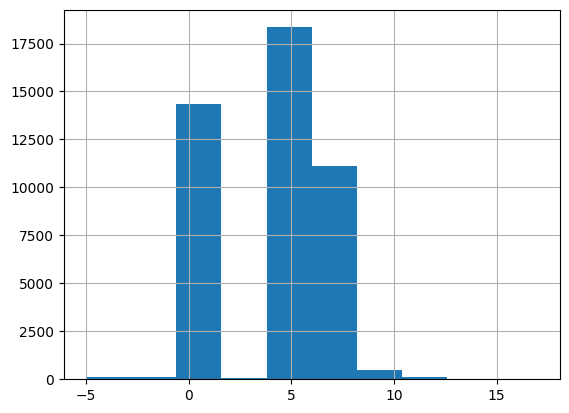

In [22]:
db_ordRev.tmp_ord_Pr_diff.hist();

In [23]:
round(db_ordRev.tmp_ord_Pr_diff.describe(),2)

count    44800.00
mean         3.77
std          2.92
min         -5.00
25%          0.00
50%          4.99
75%          6.99
max         16.97
Name: tmp_ord_Pr_diff, dtype: float64

Check Revenue/num of Orders OverTime

In [24]:
db_ordRev.sample()

,ORD_ID,ord_CreatDate,ord_TotlPaid,tmp_ord_Rev,tmp_ord_Pr_diff
7024,319083,2017-02-02 08:29:02,19.98,12.99,6.99


<AxesSubplot:xlabel='ord_CreatDate,ord_CreatDate'>

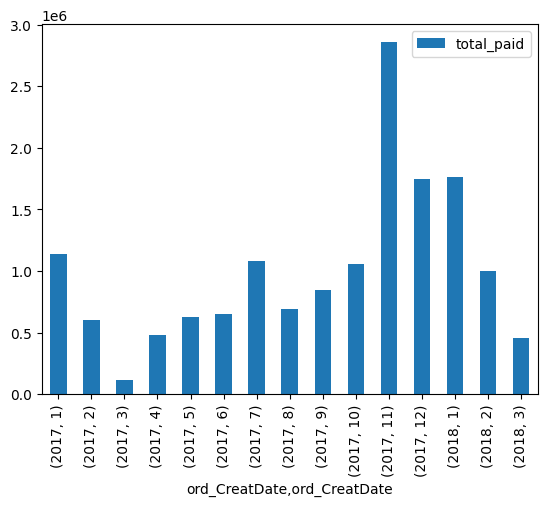

In [25]:
(
    db_ordRev
    .groupby([db_ordRev.ord_CreatDate.dt.year,db_ordRev.ord_CreatDate.dt.month])
    .agg(total_paid =("ord_TotlPaid","sum"))
    .plot(kind="bar")
)

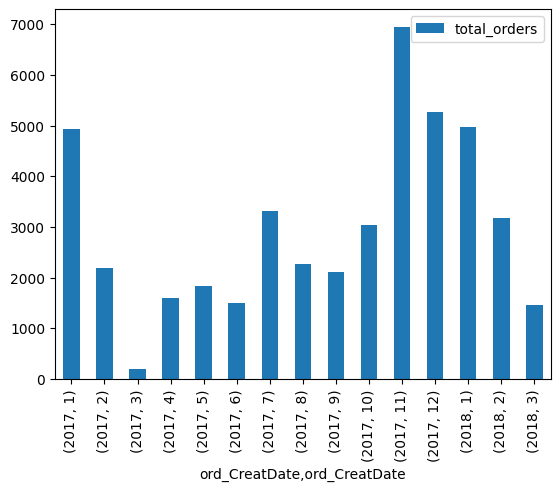

In [26]:
(
    db_ordRev
    .groupby([db_ordRev.ord_CreatDate.dt.year,db_ordRev.ord_CreatDate.dt.month])
    .agg(total_orders =("ORD_ID","count"))
    .plot(kind="bar")
);

In [27]:

dbv_Rev_Ord=(
    db_ordRev
    .groupby(db_ordRev.ord_CreatDate.dt.strftime("%Y-%m"))
    #.agg({'ord_TotlPaid': [('total_rev', 'sum')], 'ORD_ID': [('total_orders', 'count')]})
    .agg({'ord_TotlPaid': 'sum', 'ORD_ID':'count'})
    #.agg(total_rev =("tmp_ord_Rev","sum"))
    #.plot(kind="bar")
    .reset_index()
)
#Note: shall compare first 3 months of each yaer with eachother
dbv_Rev_Ord

,ord_CreatDate,ord_TotlPaid,ORD_ID
0,2017-01,1135490.96,4931
1,2017-02,598598.97,2194
2,2017-03,114301.35,195
3,2017-04,476513.19,1592
4,2017-05,627442.14,1829
5,2017-06,651734.18,1506
6,2017-07,1082488.33,3314
7,2017-08,693079.01,2270
8,2017-09,842627.94,2107
9,2017-10,1054252.24,3034


In [28]:
dbv_Rev_Ord=(
    dbv_Rev_Ord
    .assign(Q1=[1,1,1,0,0,0,0,0,0,0,0,0,1,1,1])
)

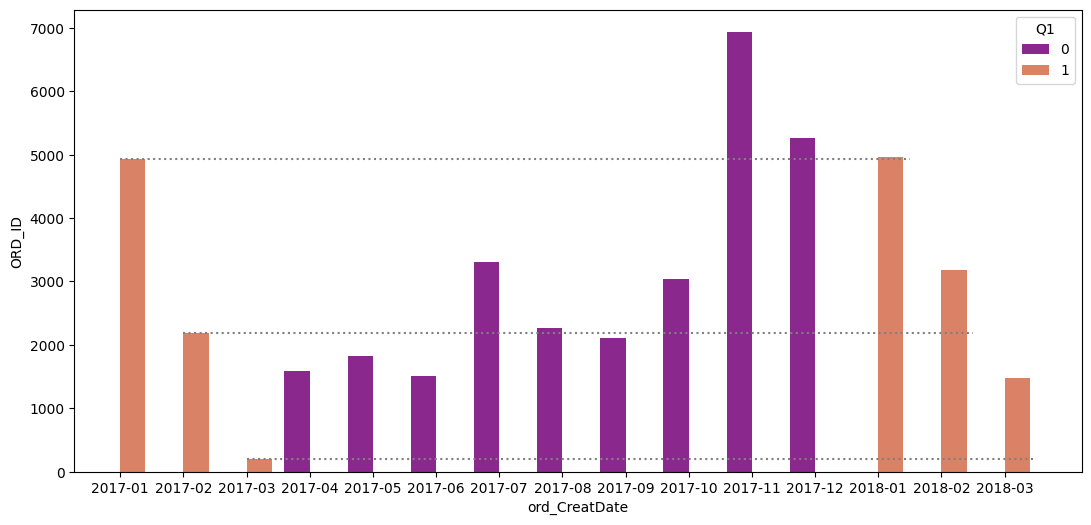

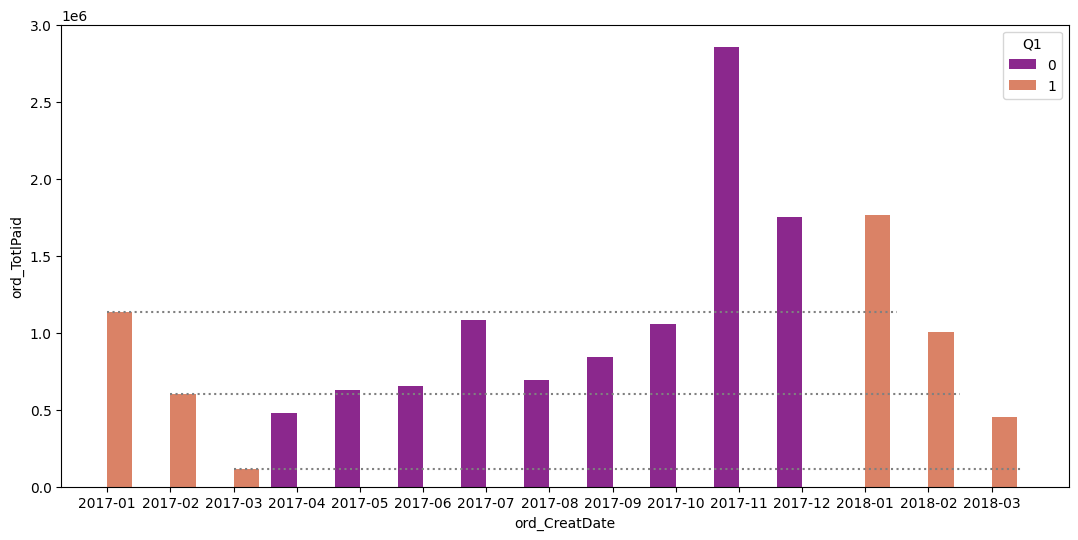

In [29]:
f,axs=plt.subplots(figsize=(13,6))
sns.barplot(data=dbv_Rev_Ord
            ,x="ord_CreatDate"
            ,y="ORD_ID"
            ,hue="Q1"
            #,legend=False
            #,aspect=3
            ,palette="plasma"
            ,ax=axs
            )
hlines=[dbv_Rev_Ord.ORD_ID[0],dbv_Rev_Ord.ORD_ID[1],dbv_Rev_Ord.ORD_ID[2]]
axs.hlines(hlines, xmin=[0,1,2],xmax=[12.5,13.5,14.5], color='grey',linestyles="dotted")
f,axs=plt.subplots(figsize=(13,6))
sns.barplot(data=dbv_Rev_Ord
            ,x="ord_CreatDate"
            ,y="ord_TotlPaid"
            ,hue="Q1"
            #,legend=False
            #,aspect=3
            ,palette="plasma"
            ,ax=axs
            )
hlines=[dbv_Rev_Ord.ord_TotlPaid[0],dbv_Rev_Ord.ord_TotlPaid[1],dbv_Rev_Ord.ord_TotlPaid[2]]
axs.hlines(hlines, xmin=[0,1,2],xmax=[12.5,13.5,14.5], color='grey',linestyles="dotted")


- Conclusion

In [30]:
print(f''' Looking to the diagram, The Revenue has been decreased for Q1 2018 WRT to q4 2017
      BUT Its normally not recommanded to compare 2 different quarters/months within year with each others.
      Best Practice recomand to compare same Quarter of different years to consider seasonal events
      Hence looking to Q1 2017, The Revenue as well as number of Orders has been already Increased!!
      Means the Main Investor concerns are not quite real''')

 Looking to the diagram, The Revenue has been decreased for Q1 2018 WRT to q4 2017
      BUT Its normally not recommanded to compare 2 different quarters/months within year with each others.
      Best Practice recomand to compare same Quarter of different years to consider seasonal events
      Hence looking to Q1 2017, The Revenue as well as number of Orders has been already Increased!!
      Means the Main Investor concerns are not quite real


### B.3/4 Discounts per product (db_proDis)
- Recap:
    - ol_ProdUntPr : the unitary price (euros) of each product at the moment of placing that order
    - pro_Pr       : product price without discounts
- check if rows are unique for sku
- discounts per product --> pro_Pr - ol_ProdUntPr

In [31]:
drop_lst_proDis =["ORD_ID","ord_CreatDate","ol_ProcessDate","ord_TotlPaid","OL_ID","ol_ProdQnty","pro_Desc","pro_InStock","tmp_ol_price"]


In [32]:
db_proDis=(
    db_qu
    #.drop(columns=drop_lst_proDis)
    #.reindex(columns=["PRO_SKU","pro_Name","pro_Type","ol_ProdUntPr","pro_Pr"])
    .assign(tmp_pro_dis = db_qu.pro_Pr - db_qu.ol_ProdUntPr)
)

In [33]:
# db_proDis.tmp_pro_dis.means = '''db_qu.pro_Pr - db_qu.ol_ProdUntPr, 
# -ve means item sold higher than original price
# 0 means no discount'''

In [34]:
(db_proDis.tmp_pro_dis == 0).sum()

2492

In [35]:

dbv_Dis_Time=(
    db_proDis
    .groupby(db_proDis.ord_CreatDate.dt.strftime("%Y-%m"))
    #.agg({'ord_TotlPaid': [('total_rev', 'sum')], 'ORD_ID': [('total_orders', 'count')]})
    .agg({'ord_TotlPaid': 'sum', 'ORD_ID':'count',"tmp_pro_dis":"sum"})
    #.agg(total_rev =("tmp_ord_Rev","sum"))
    #.plot(kind="bar")
    .reset_index()
)
dbv_Dis_Time

,ord_CreatDate,ord_TotlPaid,ORD_ID,tmp_pro_dis
0,2017-01,1777889.13,6618,238394.344
1,2017-02,905435.61,2887,88004.881
2,2017-03,210875.29,267,13277.222
3,2017-04,843396.60,2152,68707.331
4,2017-05,1012677.11,2490,83814.034
5,2017-06,1074748.50,2111,87762.395
6,2017-07,1732924.23,4665,188047.702
7,2017-08,1103649.81,3046,122925.700
8,2017-09,1325261.64,2885,143650.622
9,2017-10,1673072.68,4107,186636.886


In [36]:
dbv_Dis_Time=(
    dbv_Dis_Time
    .assign(Q1=[1,1,1,0,0,0,0,0,0,0,0,0,1,1,1])
)

C:\Users\Jacqueline\AppData\Local\Temp\ipykernel_21912\200821886.py:29: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=dbv_Dis_Time


<AxesSubplot:xlabel='ord_CreatDate', ylabel='ord_TotlPaid'>

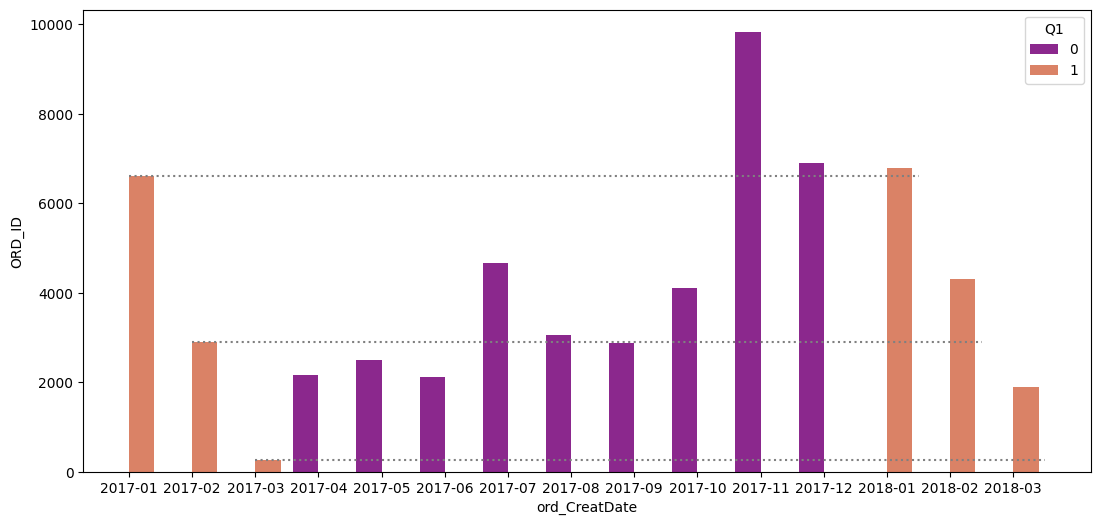

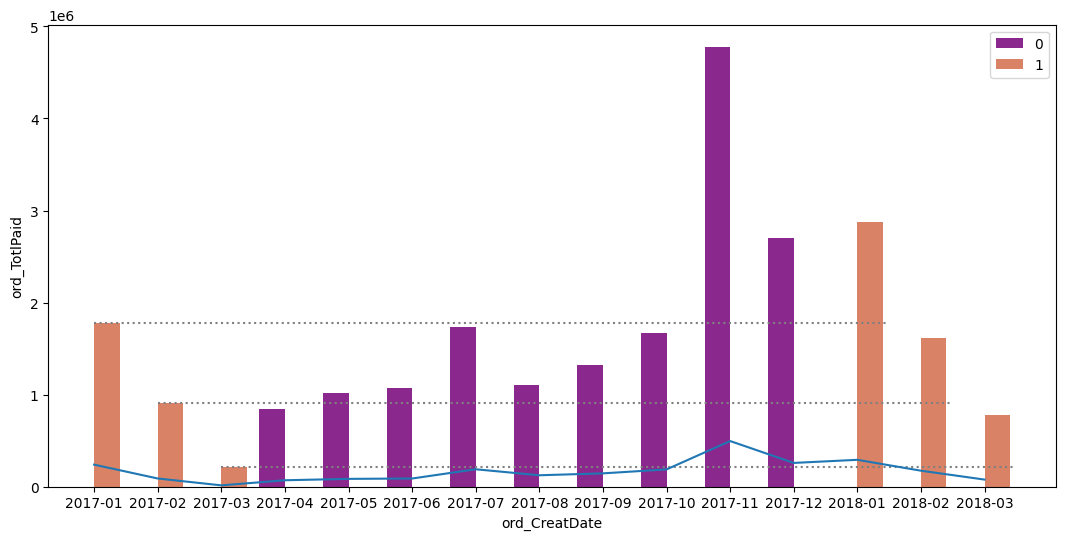

In [37]:
f,axs=plt.subplots(figsize=(13,6))
sns.barplot(data=dbv_Dis_Time
            ,x="ord_CreatDate"
            ,y="ORD_ID"
            ,hue="Q1"
            #,legend=False
            #,aspect=3
            ,palette="plasma"
            ,ax=axs
            )
hlines=[dbv_Dis_Time.ORD_ID[0],dbv_Dis_Time.ORD_ID[1],dbv_Dis_Time.ORD_ID[2]]
axs.hlines(hlines, xmin=[0,1,2],xmax=[12.5,13.5,14.5], color='grey',linestyles="dotted")


f,axs=plt.subplots(figsize=(13,6))
sns.barplot(data=dbv_Dis_Time
            ,x="ord_CreatDate"
            ,y="ord_TotlPaid"
            ,hue="Q1"
            #,legend=False
            #,aspect=3
            ,palette="plasma"
            ,ax=axs
            )
hlines=[dbv_Dis_Time.ord_TotlPaid[0],dbv_Dis_Time.ord_TotlPaid[1],dbv_Dis_Time.ord_TotlPaid[2]]
axs.hlines(hlines, xmin=[0,1,2],xmax=[12.5,13.5,14.5], color='grey',linestyles="dotted")
#axs.tick_params(direction='in')

sns.lineplot(data=dbv_Dis_Time
            ,x="ord_CreatDate"
            ,y="tmp_pro_dis"
            #,hue="Q1"
            #,legend=False
            #,aspect=3
            ,palette="plasma"
            ,ax=axs
            )

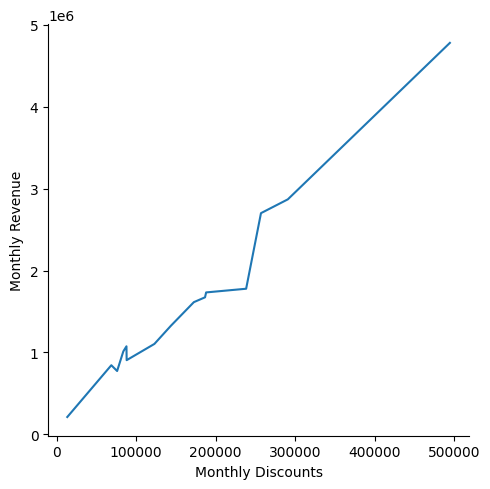

In [38]:
g=sns.relplot(data=dbv_Dis_Time
            ,kind="line"
            ,x="tmp_pro_dis"
            ,y="ord_TotlPaid")
g.set_xlabels("Monthly Discounts")
g.set_ylabels("Monthly Revenue")

In [39]:
db_proDis.sample()

,ORD_ID,ord_CreatDate,ord_TotlPaid,OL_ID,ol_ProdQnty,ol_ProdUntPr,ol_ProcessDate,PRO_SKU,pro_Name,pro_Desc,pro_Pr,pro_InStock,pro_Type,tmp_ol_price,tmp_pro_dis
22681,302054,2017-01-05 15:58:59,309.99,1126612,1,309.99,2017-01-03 21:52:42,LGE0046,"24UD58-B LG Monitor 238 ""4K UHD",238 inch monitor with 2 HDMI ports and a Displ...,349.0,True,1296,309.99,39.01


#### 3. How many products are being discounted.
    - means for tmp_pro_dis > 0
        - count unique PRO_SKU
        - count product ol_ProdQnty

In [40]:
# db_proDis.tmp_pro_dis.means

In [41]:

x=(
    db_proDis
    .query("tmp_pro_dis> 0")
    .agg(Prod_num=("PRO_SKU",pd.Series.nunique),Prod_Qnty_sum=("ol_ProdQnty","sum"))
)
x

,PRO_SKU,ol_ProdQnty
Prod_num,5681.0,NaN
Prod_Qnty_sum,NaN,63571.0


In [42]:
db_proDis.head(1)

,ORD_ID,ord_CreatDate,ord_TotlPaid,OL_ID,ol_ProdQnty,ol_ProdUntPr,ol_ProcessDate,PRO_SKU,pro_Name,pro_Desc,pro_Pr,pro_InStock,pro_Type,tmp_ol_price,tmp_pro_dis
0,241423,2017-11-06 13:10:02,136.15,1398738,1,129.16,2017-11-06 12:47:20,LAC0212,LaCie Porsche Design Desktop Drive 4TB USB 3.0...,External Hard Drive 4TB 35-inch USB 3.0 for Ma...,139.99,True,11935397,129.16,10.83


<AxesSubplot:xlabel='pro_Pr', ylabel='ol_ProdUntPr'>

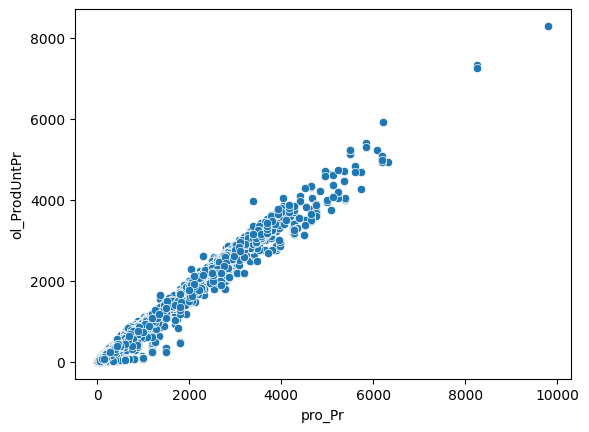

In [43]:
sns.scatterplot(data=db_proDis
                ,x="pro_Pr"
                ,y="ol_ProdUntPr"
                #,hue="PRO_SKU"
                )

- Conclusion

In [44]:
print(f" Considering Unique SKU : {round(x.PRO_SKU[0]/db_proDis.PRO_SKU.nunique()*100,2)}% of all sold product are discounted")
print(f" Considering Sum of Quantities : {round(x.ol_ProdQnty[1]/db_proDis.ol_ProdQnty.sum()*100,2)}% of all sold products Quantities are discounted")

 Considering Unique SKU : 96.53% of all sold product are discounted
 Considering Sum of Quantities : 93.01% of all sold products Quantities are discounted


In [45]:
print(f"That means specific types of products are mor in discount")

That means specific types of products are mor in discount
